In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class MSELoss:
    def forward(self, y, target):
        """
        Args:
          y of shape (n_samples, ysize): Inputs of the loss function (can be, e.g., an output of a neural network).
          target of shape (n_samples, ysize): Targets.
        
        Returns:
          loss (float): The loss value.
        """
        self.diff = diff = y - target  # Keep this for backward computations
        c = np.sum(np.square(diff)) / diff.size
        return c

    def backward(self):
        """
        Returns:
          dy of shape (n_samples, ysize): Gradient of the MSE loss wrt the inputs.
        """
        assert hasattr(self, 'diff'), "Need to call forward() first"
        dx = 2 * (self.diff) / self.diff.size
        return dx
        

In [3]:
def test_MSELoss_shapes():
    y = np.random.randn(3)
    target = np.zeros(3)  # Dummy target
    loss = MSELoss()  # Create the loss
    loss_value = loss.forward(y, target)  # Do forward computations
    dy = loss.backward()  # Do backward computations
    assert dy.shape == y.shape, f"Bad dy.shape: {dy.shape}"
    print('Success')

test_MSELoss_shapes()

Success


In [4]:
class Linear:
    def __init__(self, in_features, out_features):
        """
        Args:
          in_features (int): Number of input features which should be equal to xsize.
          out_features (out): Number of output features which should be equal to ysize.
        """
        self.in_features = in_features
        self.out_features = out_features
        
        # Initialize the weights
        bound = 3 / np.sqrt(in_features)
        self.W = np.random.uniform(-bound, bound, (out_features, in_features))
        bound = 1 / np.sqrt(in_features)
        self.b = np.random.uniform(-bound, bound, out_features)

        self.grad_W = None  # Attribute to store the gradients wrt W
        self.grad_b = None  # Attribute to store the gradients wrt b

    def forward(self, x):
        """
        Args:
          x of shape (n_samples, xsize): Inputs
        
        Returns:
          y of shape (n_samples, ysize): Outputs of shape.
        """
        self.x = x  # Keep this for backward computations
        return linear_forward(x, self.W, self.b)

    def backward(self, dy):
        """
        Args:
          dy of shape (n_samples, ysize): Gradient of a loss wrt outputs.
        
        Returns:
          dx of shape (n_samples, xsize): Gradient of a loss wrt inputs.
        """
        assert hasattr(self, 'x'), "Need to call forward() first"
        assert dy.ndim == 2 and dy.shape[1] == self.W.shape[0]
        dx, self.grad_W, self.grad_b = linear_backward(dy, self.x, self.W, self.b)
        return dx

In [5]:
def linear_forward(x, W, b):
    """Forward computations in the linear layer:
        y = W x + b

    Args:
      x of shape (n_samples, xsize): Inputs .
      W of shape (ysize, xsize): Weight matrix.
      b of shape (ysize,): Bias term.

    Returns:
      y of shape (n_samples, ysize): Outputs.
    """
    y = np.dot(x, W.T)
    y = y + b

    return y

    
def linear_backward(dy, x, W, b):
    """Backward computations in the linear layer.

    Args:
      dy of shape (n_samples, ysize): Gradient of a loss wrt outputs.
      x of (n_samples, xsize): Input of shape.
      W of shape (ysize, xsize): Weight matrix.
      b of shape (ysize,): Bias term.

    Returns:
      dx of shape (n_samples, xsize): Gradient of a loss wrt inputs.
      dW of shape (ysize, xsize): Gradient wrt weight matrix W.
      db of shape (ysize,): Gradient wrt bias term b.
    """
    assert dy.ndim == 2 and dy.shape[1] == W.shape[0]
    dW = np.dot(dy.T, x)
    db = np.sum(dy, axis=0)
    dx = np.dot(dy, W)
    return dx, dW, db



In [6]:
# We test the shapes of the outputs
def test_linear_shapes():
    n_samples = 4
    x = np.random.randn(n_samples, 2)
    W = np.random.randn(3, 2)
    b = np.random.randn(3)

    # Test shapes
    y = linear_forward(x, W, b)
    dy = np.arange(n_samples * 3).reshape((n_samples, 3))
    dx, dW, db = linear_backward(dy, x, W, b)
    assert dx.shape == x.shape, f"Bad dx.shape={dx.shape}, x.shape={x.shape}"
    assert dW.shape == W.shape, f"Bad dW.shape={dW.shape}, W.shape={W.shape}"
    assert db.shape == b.shape, f"Bad db.shape={db.shape}, b.shape={b.shape}"

    print('Success')

test_linear_shapes()

Success


In [7]:
class Tanh:
    def forward(self, x):
        """
        Args:
          x (array): Input of shape (n_features,).
        
        Returns:
          y (array): Output of shape (n_features,).
        """
        self.x = x
        y = np.tanh(x)
        return y

    def backward(self, dy):
        """
        Args:
          dy (array): Gradient of a loss wrt outputs, shape (n_features,).
        
        Returns:
          dx (array): Gradient of a loss wrt inputs, shape (n_features,).
        """
        assert hasattr(self, 'x'), "Need to call forward() first."
        dx = (1 - (np.tanh(self.x))**2) * dy
        return dx

In [8]:
def test_Tanh_shapes():
    x = np.random.randn(3)
    act_fn = Tanh()
    y = act_fn.forward(x)
    dy = np.arange(1, 4)
    dx = act_fn.backward(dy)
    assert dx.shape == x.shape, f"Bad dx.shape: {dx.shape}"
    print('Success')

test_Tanh_shapes()

Success


In [9]:
class MLP:
    def __init__(self, in_features, hidden_size1, hidden_size2, out_features):
        """
        Args:
          in_features (int): Number of inputs which should be equal to xsize.
          hidden_size1 (int): Number of units in the first hidden layer.
          hidden_size2 (int): Number of units in the second hidden layer.
          out_features (int): Number of outputs which should be equal to ysize.
        """
        self.fc1 = Linear(in_features, hidden_size1)
        self.fc2 = Linear(hidden_size1, hidden_size2)
        self.fc3 = Linear(hidden_size2, out_features)
        self.tanh2 = Tanh()
        self.tanh = Tanh()

    def forward(self, x):
        """
        Args:
          x (array): Input of shape [N, xsize].
        
        Returns:
          y (array): Output of shape [N, ysize].
        """
        x = self.fc1.forward(x)
        x = self.tanh.forward(x)
        x = self.fc2.forward(x)
        x = self.tanh2.forward(x)
        x = self.fc3.forward(x)
        return x

    def backward(self, dy):
        """
        Args:
          dy (array): Gradient of a loss wrt outputs (shape [N, ysize]).
        
        Returns:
          dx (array): Gradient of a loss wrt inputs (shape [N, xsize]).
        """
        dy = self.fc3.backward(dy)
        dy = self.tanh2.backward(dy)
        dy = self.fc2.backward(dy)
        dy = self.tanh.backward(dy)
        dy = self.fc1.backward(dy)
        return dy
    


In [10]:
def test_MLP_shapes():
    n_samples = 10
    x = np.random.randn(n_samples, 1)
    mlp_batch = MLP(1, 10, 20, 1)
    y = mlp_batch.forward(x)

    dy = np.arange(n_samples).reshape((n_samples, 1))   # Dummy gradient of a loss function wrt MLP's outputs.
    dx = mlp_batch.backward(dy)
    assert dx.shape == x.shape, f"Bad dx.shape={dx.shape}, x.shape={x.shape}"
    print('Success')

test_MLP_shapes()

Success


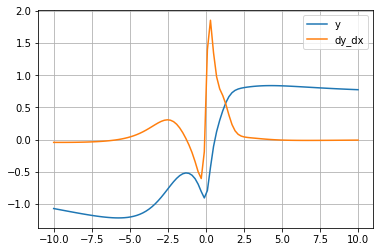

In [11]:
# Let's create an MLP with random weights and compute the derivative wrt the one-dimensional input
def test_MLP_derivative():
    n_samples = 100
    x = np.linspace(-10, 10, n_samples)
    mlp_batch = MLP(1, 10, 20, 1)
    y = mlp_batch.forward(x.reshape((n_samples, 1))).flatten()

    dy_dx = mlp_batch.backward(np.ones((n_samples, 1))).flatten()

    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.plot(x, dy_dx)
    ax.grid(True)
    ax.legend(['y', 'dy_dx'])

test_MLP_derivative()

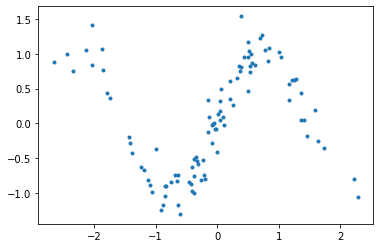

In [12]:
# Lets generate toy data
np.random.seed(2)
x = np.random.randn(100, 1)
x = np.sort(x, axis=0)
targets = np.sin(x * 2 * np.pi / 3)
targets = targets + 0.2 * np.random.randn(*targets.shape)

# Plot the data
fig, ax = plt.subplots(1)
ax.plot(x, targets, '.')

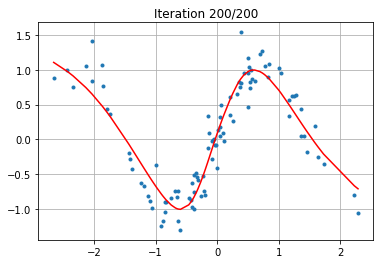

In [14]:
# And train an MLP network using gradient descent
from IPython import display

# The trained MLP is not tested
mlp = MLP(1, 10, 11, 1)  # Create MLP network
loss = MSELoss()  # Create loss

fig, ax = plt.subplots(1)
ax.plot(x, targets, '.')
learning_rate = 0.05
n_epochs = 200
for i in range(n_epochs):
    # Forward computations
    y = mlp.forward(x)
    c = loss.forward(y, targets)

    # Backward computations
    dy = loss.backward()
    dx = mlp.backward(dy)

    # Gradient descent update
    #learning_rate *= 0.99  # Learning rate annealing
    for module in mlp.__dict__.values():
        if hasattr(module, 'W'):
            module.W = module.W - module.grad_W * learning_rate
            module.b = module.b - module.grad_b * learning_rate

    ax.clear()
    ax.plot(x, targets, '.')
    ax.plot(x, y, 'r-')
    ax.grid(True)
    ax.set_title('Iteration %d/%d' % (i+1, n_epochs))
    display.clear_output(wait=True)
    display.display(fig)
    plt.pause(0.005)
display.clear_output(wait=True)